In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [2]:
dataset = 'kitti'
annot_dir = '../kitti/training_coco'
imgs_dir = '../kitti/training_voc/VOC2012/JPEGImages'

for split in ['train', 'val']: 
    annot_path = os.path.join(annot_dir, f'{split}.json')
    d_name = dataset + f'_{split}'
    register_coco_instances(d_name, {}, annot_path, imgs_dir)

In [3]:
# Load dataset
dataset_dicts = DatasetCatalog.get('kitti_train')
metadata = MetadataCatalog.get('kitti_train')

[03/08 12:00:21 d2.data.datasets.coco]: Loaded 5984 images in COCO format from ../kitti/training_coco/train.json


In [4]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate

cfg = LazyConfig.load("./detectron2/model_zoo/configs/COCO-Detection/retinanet_R_50_FPN_1x.py")
cfg.train.device = 'mps'
cfg.dataloader.evaluator.dataset_name = 'kitti_val'
cfg.dataloader.train.dataset.names = 'kitti_train'

In [5]:
print(LazyConfig.to_py(cfg))

cfg.dataloader.evaluator = detectron2.evaluation.COCOEvaluator(dataset_name="kitti_val")
cfg.dataloader.test = detectron2.data.build_detection_test_loader(
    dataset=detectron2.data.get_detection_dataset_dicts(
        filter_empty=False, names="coco_2017_val"
    ),
    mapper=detectron2.data.DatasetMapper(
        augmentations=[
            detectron2.data.transforms.ResizeShortestEdge(
                max_size=1333, short_edge_length=800
            )
        ],
        image_format="BGR",
        is_train=False,
    ),
    num_workers=4,
)
cfg.dataloader.train = detectron2.data.build_detection_train_loader(
    dataset=detectron2.data.get_detection_dataset_dicts(names="kitti_train"),
    mapper=detectron2.data.DatasetMapper(
        augmentations=[
            detectron2.data.transforms.ResizeShortestEdge(
                max_size=1333,
                sample_style="choice",
                short_edge_length=[640, 672, 704, 736, 768, 800],
            ),
            detectron2.d

In [6]:
type(cfg.model)

omegaconf.dictconfig.DictConfig

In [7]:
#cfg.train.device = 'mps'
retina_net = instantiate(cfg.model)

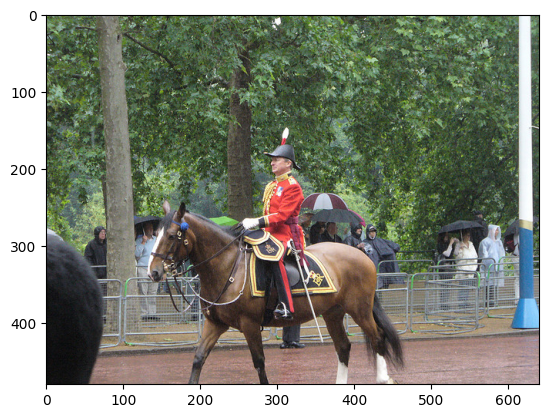

In [8]:
import matplotlib.pyplot as plt
import cv2

im = cv2.imread("./input.jpg")
plt.imshow(im[..., ::-1])

In [9]:
retina_net.device

device(type='cpu')

In [10]:
retina_net.training = False

In [11]:
retina_net.training

False

In [12]:
from detectron2.checkpoint import DetectionCheckpointer
DetectionCheckpointer(retina_net).load("detectron2://ImageNetPretrained/MSRA/R-50.pkl")

[03/08 12:00:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-50.pkl ...
[03/08 12:00:28 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[03/08 12:00:28 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
backbone.top_block.p6.{bias, weight}
backbone.top_block.p7.{bias, weight}
head.bbox_pred.{bias, weight}
head.bbox_subnet.0.{bias, weight}
head.bbox_subnet.2.{bias, weight}
head.bbox_subnet.4.{bias, weight}
head.bbox_subnet.6.{bias, weight}
head.cls_score.{bias, weight}
head.cls_subnet.0.{bias, weight}
head.cls_subnet.2.{bias, weight}
head.cls_subnet.4.{bias, weight}
head.cls_subnet.6.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  stem.conv1.bias


{'__author__': 'Caffe2', 'matching_heuristics': True}

In [13]:
retina_net

RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock(


In [13]:
import numpy as np
import torch

im = torch.tensor(im)

In [14]:
im = im.permute(2, 0, 1)

In [15]:
batched_inputs = [{
    'image': im
}]

In [16]:
outputs = retina_net(batched_inputs)

/Users/giakhang/miniconda3/envs/hope_to_public_net/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025539291/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
outputs

[{'instances': Instances(num_instances=0, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([], size=(0, 4), grad_fn=<ViewBackward0>)), scores: tensor([], grad_fn=<IndexBackward0>), pred_classes: tensor([], dtype=torch.int64)])}]

In [5]:
import argparse

class Args(argparse.Namespace):
    config_file='detectron2/model_zoo/configs/COCO-Detection/retinanet_R_50_FPN_1x.py'
    eval_only=False
    num_gpus=1
    num_machines=1
    resume=False

args = Args()

In [6]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate

cfg = LazyConfig.load("./detectron2/model_zoo/configs/COCO-Detection/retinanet_R_50_FPN_1x.py")
cfg.train.device = 'mps'
cfg.dataloader.evaluator.dataset_name = 'kitti_val'
cfg.dataloader.train.dataset.names = 'kitti_train'

In [7]:
from detectron2.engine import default_setup

In [8]:
default_setup(cfg, args)

[03/07 10:43:32 detectron2]: Rank of current process: 0. World size: 1
[03/07 10:43:32 detectron2]: Rank of current process: 0. World size: 1
[03/07 10:43:33 detectron2]: Environment info:
-------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sy

In [11]:
from tools.lazyconfig_train_net import do_train

do_train(args, cfg)

[03/04 16:50:25 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

Exception ignored in: <generator object _shard_iterator_dataloader_worker at 0x151d74120>
Traceback (most recent call last):
  File "/Users/giakhang/dev/work/sand_box/hope_to_public_net/detectron2/detectron2/data/common.py", line 48, in _shard_iterator_dataloader_worker
Exception ignored in: <generator object _shard_iterator_dataloader_worker at 0x145cb4120>
Traceback (most recent call last):
  File "/Users/giakhang/dev/work/sand_box/hope_to_public_net/detectron2/detectron2/data/common.py", line 48, in _shard_iterator_dataloader_worker
Exception ignored in: <generator object _shard_iterator_dataloader_worker at 0x162034120>
Traceback (most recent call last):
  File "/Users/giakhang/dev/work/sand_box/hope_to_public_net/detectron2/detectron2/data/common.py", line 48, in _shard_iterator_dataloader_worker
Exception ignored in: <generator object _shard_iterator_dataloader_worker at 0x14abf4120>
Traceback (most recent call last):
  File "/Users/giakhang/dev/work/sand_box/hope_to_public_net/d

[03/04 16:50:48 d2.engine.hooks]: Total training time: 0:00:22 (0:00:00 on hooks)
[03/04 16:50:48 d2.engine.hooks]: Total training time: 0:00:22 (0:00:00 on hooks)
[03/04 16:50:48 d2.utils.events]:  iter: 0       lr: N/A  
[03/04 16:50:48 d2.utils.events]:  iter: 0       lr: N/A  
Unexpected exception formatting exception. Falling back to standard exception


s/giakhang/dev/work/sand_box/hope_to_public_net/detectron2/detectron2/data/common.py", line 30, in _roundrobin
    yield from _roundrobin(
  File "/Users/giakhang/dev/work/sand_box/hope_to_public_net/detectron2/detectron2/data/common.py", line 30, in _roundrobin
    yield from _roundrobin(
  File "/Users/giakhang/dev/work/sand_box/hope_to_public_net/detectron2/detectron2/data/common.py", line 30, in _roundrobin
    yield next()
KeyboardInterrupt: 
    yield next()
KeyboardInterrupt: 
    yield next()
KeyboardInterrupt: 
    yield from _roundrobin(
  File "/Users/giakhang/dev/work/sand_box/hope_to_public_net/detectron2/detectron2/data/common.py", line 30, in _roundrobin
    yield next()
KeyboardInterrupt: 
Traceback (most recent call last):
  File "/Users/giakhang/miniconda3/envs/hope_to_public_net/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/60/189wnrq55d1c0vtyzbynj6cw000

In [14]:
train_loader = instantiate(cfg.dataloader.train)

[03/08 12:00:38 d2.data.datasets.coco]: Loaded 5984 images in COCO format from ../kitti/training_coco/train.json
[03/08 12:00:38 d2.data.build]: Removed 0 images with no usable annotations. 5984 images left.
[03/08 12:00:38 d2.data.build]: Distribution of instances among all 9 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    Cyclist    | 1311         |  DontCare  | 9027         |    Misc    | 759          |
| Person_sitt.. | 184          |    Tram    | 405          |   Truck    | 872          |
|      Van      | 2343         |    car     | 22873        |   person   | 3548         |
|               |              |            |              |            |              |
|     total     | 41322        |            |              |            |              |
[03/08 12:00:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training

In [15]:
batched_input = next(iter(train_loader))

In [16]:
retinanet = instantiate(cfg.model)

In [17]:
retinanet.backbone.size_divisibility

32

In [18]:
retinanet.backbone.padding_constraints

{'square_size': 0}

In [19]:
from detectron2.structures import ImageList

images = [x['image'] for x in batched_input]
images = ImageList.from_tensors(images, 
                                32,
                                padding_constraints=retinanet.backbone.padding_constraints)

In [20]:
type(images)

detectron2.structures.image_list.ImageList

In [21]:
images.image_sizes

[(402, 1333),
 (403, 1333),
 (402, 1333),
 (404, 1333),
 (402, 1333),
 (402, 1333),
 (403, 1333),
 (402, 1333),
 (402, 1333),
 (402, 1333),
 (402, 1333),
 (402, 1333),
 (402, 1333),
 (402, 1333),
 (402, 1333),
 (402, 1333)]

In [22]:
images.tensor.shape

torch.Size([16, 3, 416, 1344])

In [23]:
image = images.tensor[0]

In [71]:
image = image.permute(1, 2, 0)

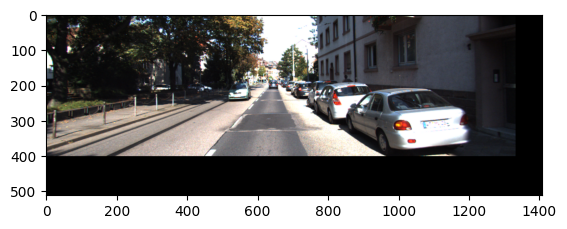

In [72]:
plt.imshow(image.numpy()[..., ::-1])

In [76]:
retinanet.backbone.padding_constraints

{'square_size': 0}

In [80]:
retinanet.box_reg_loss_type

'smooth_l1'